In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

import binarybrain as bb

import cv2

In [2]:
# 画像読み込み
imgs = []
masks = []
for i in range(23):
    img = cv2.imread('./data/metal_nut/test/scratch/%03d.png'%i)
    mask = cv2.imread('./data/metal_nut/ground_truth/scratch/%03d_mask.png'%i, 0)
    img = img.transpose(2, 0, 1).astype(np.float32) / 255.0
    mask = mask.reshape(1, 700, 700).astype(np.float32) / 255.0
    imgs.append(img)
    masks.append(mask)

In [3]:
# 学習用とテスト用に分ける
train_imgs  = np.array(imgs[0:20])
train_masks = np.array(masks[0:20])
test_imgs  = np.array(imgs[20:23])
test_masks = np.array(masks[20:23])

In [4]:
def split_image(imgs, masks, h, w, margin):
    '''タイル状に分割'''
    img_w = imgs[0].shape[2]
    img_h = imgs[0].shape[1]
    stride_h = h-margin
    stride_w = w-margin
    split_imgs  = []
    split_masks = []
    for img, msk, in zip(imgs, masks):
        for y in range(0, img_h-h, stride_h):
            for x in range(0, img_w-w, stride_w):
                blk_img = img[:,y:y+src_h,x:x+src_w]
                blk_msk = msk[:,y:y+src_h,x:x+src_w]
                if margin > 0:
                    blk_msk = blk_msk[:,margin:-margin,margin:-margin]
                split_imgs.append(blk_img)
                split_masks.append(blk_msk)
    return split_imgs, split_masks

In [5]:
bin_mode = True
frame_modulation_size = 3
depth_modulation_size = 15

epochs          = 32
mini_batch_size = 32

depth  = 4
margin = depth
src_w = 64
src_h = 64
dst_w = src_w - 2*margin
dst_h = src_h - 2*margin

In [6]:
train_x, train_t = split_image(train_imgs, train_masks, src_w, src_h, margin)
test_x, test_t = split_image(test_imgs, test_masks, src_w, src_h, margin)

In [10]:
class MyDatasets(torch.utils.data.Dataset):
    def __init__(self, source_imgs, teaching_imgs, batch_size, transforms=None):
        self.transforms = transforms
        self.source_imgs = source_imgs
        self.teaching_imgs = teaching_imgs
        
    def __len__(self):
        return len(self.source_imgs)
    
    def __getitem__(self, index):
        source_img = self.source_imgs[index]
        teaching_img = self.teaching_imgs[index]
        if self.transforms:
            source_img, teaching_img = self.transforms(source_img, teaching_img)
        return source_img, teaching_img


my_dataset_train = MyDatasets(train_x, train_t, mini_batch_size)
my_dataset_test  = MyDatasets(test_x, test_t, mini_batch_size)
loader_train = torch.utils.data.DataLoader(dataset=my_dataset_train, batch_size=mini_batch_size, shuffle=True)
loader_test  = torch.utils.data.DataLoader(dataset=my_dataset_test, batch_size=mini_batch_size, shuffle=False)

In [12]:
bin_dtype = bb.DType.BIT if bin_mode else bb.DType.FP32

def make_conv_layer(batch_norm=True, filter_size=(3,3), padding='valid', bin_dtype=bin_dtype):
       return bb.Convolution2d(
               bb.Sequential([
                   bb.DifferentiableLut([256],  connection='random', bin_dtype=bin_dtype),
                   bb.DifferentiableLut([36*6], batch_norm=batch_norm, connection='serial', bin_dtype=bin_dtype),
                   bb.DifferentiableLut([36],   batch_norm=batch_norm, connection='serial', bin_dtype=bin_dtype),
               ]), padding=padding, filter_size=filter_size, fw_dtype=bin_dtype)

# ネット定義
core_net = bb.Sequential([])
for i in range(depth-1):
    core_net.append(make_conv_layer(batch_norm=True, bin_dtype=bin_dtype))
core_net.append(make_conv_layer(batch_norm=True, bin_dtype=bin_dtype))

#core_net.append(make_conv_layer([1], bin_dtype=bin_dtype))

if bin_mode:
    net = bb.Sequential([
            bb.RealToBinary(frame_modulation_size=frame_modulation_size, depth_modulation_size=depth_modulation_size, bin_dtype=bin_dtype),
            core_net,
            bb.BinaryToReal(frame_modulation_size=frame_modulation_size, bin_dtype=bin_dtype),
            bb.Reduce([1, dst_h, dst_w]),
            bb.Sigmoid(),
        ])
else:
    net = bb.Sequential([
            core_net,
            bb.Reduce([1, dst_h, dst_w]),
            bb.Sigmoid(),
        ])
    

net.set_input_shape([3, src_h, src_w])

print(net.get_info(2))

  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {3, 64, 64}   output shape : {45, 64, 64}
  --------------------------------------------------------------------
  [Sequential] 
   input  shape : {45, 64, 64}   output shape : {36, 58, 58}
  --------------------------------------------------------------------
  [BinaryToReal] 
   input  shape : {36, 56, 56}   output shape : {36, 56, 56}
  --------------------------------------------------------------------
  [Reduce] 
   input  shape : {36, 56, 56}   output shape : {1, 56, 56}
  --------------------------------------------------------------------
  [Sigmoid] 
   input  shape : {}   output shape : {}



In [13]:
# learning
net.set_input_shape([3, src_h, src_w])

bb.load_networks('.data/Scratch_LutCnn', net)

loss      = bb.LossMeanSquaredError()
optimizer = bb.OptimizerAdam()

optimizer.set_variables(net.get_parameters(), net.get_gradients())

for epoch in range(epochs):
    # training
    loss.clear()
    with tqdm(loader_train) as tqdm_loadr:
        for x_imgs, t_imgs in tqdm_loadr:
            x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
            t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))
            
            y_buf = net.forward(x_buf, train=True)
            dy_buf = loss.calculate(y_buf, t_buf)
            
            net.backward(dy_buf)
            optimizer.update()
            
            tqdm_loadr.set_postfix(loss=loss.get())
    train_loss = loss.get()
    
    # test
    loss.clear()
    for x_imgs, t_imgs in loader_test:
        x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
        t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))

        y_buf = net.forward(x_buf, train=False)

        loss.calculate(y_buf, t_buf)
    test_loss = loss.get()
    
    bb.save_networks('.data/Scratch_LutCnn', net)

    print('epoch[%d] : train_loss=%f test_loss=%f' % (epoch, train_loss, test_loss))

load : .data/Scratch_LutCnn\20210104_181222



epoch[0] : train_loss=0.264469 test_loss=0.266655



epoch[1] : train_loss=0.262420 test_loss=0.255713



epoch[2] : train_loss=0.260258 test_loss=0.269798



epoch[3] : train_loss=0.260227 test_loss=0.252203



epoch[4] : train_loss=0.260258 test_loss=0.258009



epoch[5] : train_loss=0.260227 test_loss=0.260568



epoch[6] : train_loss=0.260255 test_loss=0.269796



epoch[7] : train_loss=0.260315 test_loss=0.256855



epoch[8] : train_loss=0.259715 test_loss=0.255019



epoch[9] : train_loss=0.259436 test_loss=0.265970



epoch[10] : train_loss=0.259531 test_loss=0.253973



epoch[11] : train_loss=0.260642 test_loss=0.260057



epoch[12] : train_loss=0.260662 test_loss=0.261434



epoch[13] : train_loss=0.260421 test_loss=0.265910



epoch[14] : train_loss=0.261197 test_loss=0.249762



epoch[15] : train_loss=0.261444 test_loss=0.256383



epoch[16] : train_loss=0.261175 test_loss=0.255318



epoch[17] : train_loss=0.260298 test_loss=0.263472



epoch[18] : train_loss=0.261775 test_loss=0.269890



epoch[19] : train_loss=0.263685 test_loss=0.251823



epoch[20] : train_loss=0.262423 test_loss=0.258439


KeyboardInterrupt: 

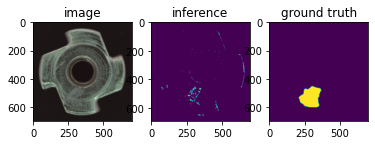

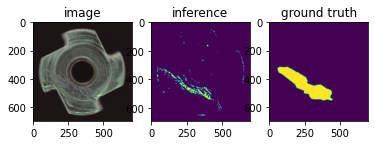

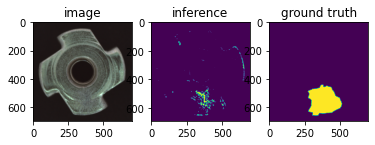

In [15]:
valid_net = bb.Sequential([
                bb.RealToBinary(frame_modulation_size=frame_modulation_size, depth_modulation_size=depth_modulation_size, bin_dtype=bin_dtype),
                core_net,
                bb.BinaryToReal(frame_modulation_size=frame_modulation_size, bin_dtype=bin_dtype),
                bb.Reduce([1, 700-2*margin, 700-2*margin]),
                bb.Sigmoid(),
            ])
    
valid_net.set_input_shape([3, 700,700])

for i in range(3):
    x_buf = bb.FrameBuffer.from_numpy(test_imgs[i:i+1])
    t_buf = bb.FrameBuffer.from_numpy(test_masks[i:i+1])
    y_buf = valid_net.forward(x_buf, train=False)
    plt.subplot(131)
    plt.title('image')
    plt.imshow(x_buf.numpy()[0].transpose(1, 2, 0))    
    plt.subplot(132)
    plt.title('inference')
    plt.imshow(y_buf.numpy()[0][0] > 0.7)
    plt.subplot(133)
    plt.title('ground truth')
    plt.imshow(t_buf.numpy()[0][0])
    plt.show()